In [1]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
import train
from train import MLP
from Layer import Layer
from sklearn.metrics import mean_squared_error as mse 
from matplotlib import pyplot as plt
import loadmodel

In [2]:
df=pd.read_csv('covid-data.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [3]:
df=df.dropna(subset=['continent'])  #drop the rows of international and world as they dont have continent
data=df.loc[:,['continent','location','date','new_cases','new_deaths']] 

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34590 entries, 0 to 34589
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   continent   34590 non-null  object 
 1   location    34590 non-null  object 
 2   date        34590 non-null  object 
 3   new_cases   34249 non-null  float64
 4   new_deaths  34249 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.6+ MB


In [5]:
data.describe()

,new_cases,new_deaths
count,34249.000000,34249.000000
mean,540.713101,20.454086
std,3373.001050,122.794996
min,-2461.000000,-1918.000000
25%,0.000000,0.000000
50%,6.000000,0.000000
75%,105.000000,2.000000
max,78427.000000,4928.000000


In [6]:
data.isnull().sum()

continent       0
location        0
date            0
new_cases     341
new_deaths    341
dtype: int64

In [7]:
#Imputing the null values using backward fill and #converting continent and location to category

data['new_cases'].fillna(method='bfill',inplace=True)
data['new_deaths'].fillna(method='bfill',inplace=True)
data['continent'].astype('category')
data['location'].astype('category')

0        Afghanistan
1        Afghanistan
2        Afghanistan
3        Afghanistan
4        Afghanistan
            ...     
34585       Zimbabwe
34586       Zimbabwe
34587       Zimbabwe
34588       Zimbabwe
34589       Zimbabwe
Name: location, Length: 34590, dtype: category
Categories (210, object): [Afghanistan, Albania, Algeria, Andorra, ..., Western Sahara, Yemen, Zambia, Zimbabwe]

In [8]:
data['date'] =  pd.to_datetime(data['date']) #convert date to date-time
k=[]
for x in data['date']:
    k.append(int((x-data['date'][0]).days))           #calculate Day from Data from Day0 to Day217
df2=pd.DataFrame(k,index=None,columns=['Day'])              
data['Day']=df2
pn=[]
p_d=[]
prev=0
for x in range(0,data.shape[0]):
    if(data['Day'][x]==0):                          #calculate previousDay newcases
        pn.append(prev)
    else:
        pn.append(data['new_cases'][x-1])
d2=pd.DataFrame(pn,columns=['Previous_day case'])
data['prev_new_cases']=d2
p_d=[]
prev=0
for x in range(0,data.shape[0]):
    if(data['Day'][x]==0):
        p_d.append(prev)
    else:
        p_d.append(data['new_deaths'][x-1])      #calculate previous day new deaths
d2=pd.DataFrame(p_d,columns=['Previous_day death'])
data['prev_day_death']=d2

In [9]:
te=TargetEncoder()              #Target encoder to encode location based on the target variable New_cases
le=LabelEncoder()               #LabelEncoder to encode continent
St=StandardScaler()             #StandardScaler to Scale features
minmax=MinMaxScaler(feature_range=(-10,10))   #MinMax scaler to scale features
data['Continent_encoded']=le.fit_transform(data['continent'])
data['Location_encoded']=te.fit_transform(data['location'],data['new_cases'])

In [10]:
data.corr()


,new_cases,new_deaths,Day,prev_new_cases,prev_day_death,Continent_encoded,Location_encoded
new_cases,1.000000,0.726937,0.102524,0.963944,0.708586,0.109789,0.641004
new_deaths,0.726937,1.000000,0.054284,0.699623,0.866537,0.125751,0.569142
Day,0.102524,0.054284,1.000000,0.101088,0.053854,-0.011171,-0.072206
prev_new_cases,0.963944,0.699623,0.101088,1.000000,0.726883,0.109262,0.633513
prev_day_death,0.708586,0.866537,0.053854,0.726883,1.000000,0.124978,0.563354
Continent_encoded,0.109789,0.125751,-0.011171,0.109262,0.124978,1.000000,0.171277
Location_encoded,0.641004,0.569142,-0.072206,0.633513,0.563354,0.171277,1.000000


In [11]:
data.sort_values(['Day','location'],ascending=[True,True],inplace=True)  #sort according to day 

In [12]:
#Test train split
#Day>200 are in Training set and rest in Test Set
train_data=data[data['Day']<=200]
test_data=data[data['Day']>200]
train_data=train_data.sample(frac=1)   #randomly shuffling the Trainingset
train_data.describe()

,new_cases,new_deaths,Day,prev_new_cases,prev_day_death,Continent_encoded,Location_encoded
count,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000
mean,455.548787,19.371675,121.888154,452.491209,19.273161,1.707474,547.195223
std,2762.389997,119.708495,50.721788,2750.829569,119.594489,1.376435,2181.121557
min,-2461.000000,-1918.000000,0.000000,-2461.000000,-1918.000000,0.000000,0.022727
25%,0.000000,0.000000,89.000000,0.000000,0.000000,1.000000,6.330709
50%,4.000000,0.000000,127.000000,4.000000,0.000000,2.000000,41.136986
75%,83.000000,2.000000,164.000000,82.000000,2.000000,2.000000,280.374429
max,76930.000000,4928.000000,200.000000,76930.000000,4928.000000,5.000000,21785.785388


In [13]:
#SPLITTING TRAINING SET INTO INPUT FEATURES FOR NET1,NET2 AND TARGET VARAIBLE
X_net1_train=train_data.loc[:,['Continent_encoded','Location_encoded']]  
Y_train=train_data.loc[:,['new_cases','new_deaths']]
X_net2_train=train_data.loc[:,['Day','prev_new_cases','prev_day_death']]

In [14]:
#SPLITTING CROSS VALIDATION SET INTO INPUT FEATURES FOR NET1,NET2 AND TARGET VARAIBLE
cv_data=train_data[18497:]
X_net1_cv=cv_data.loc[:,['Continent_encoded','Location_encoded']]
Y_cv=cv_data.loc[:,['new_cases','new_deaths']]
X_net2_cv=cv_data.loc[:,['Day','prev_new_cases','prev_day_death']]


In [15]:
#Test set processing and splitting
test_data=test_data[test_data['location']!='Hong Kong']
test_data=test_data[test_data['Day']<218]
test_days=test_data['Day'].to_numpy()
X_test_net1=test_data.loc[:,['Continent_encoded','Location_encoded']]
X_test_net2=test_data.loc[:,['prev_new_cases','prev_day_death']]

In [16]:
print('shape of Input features of Neural Network1 '+str(X_net1_train.shape))
print('shape of Input features of Neural Network1 '+ str(X_net2_train.shape))
print('shape of Target of Neural Network '+ str(Y_train.shape))

shape of Input features of Neural Network1 (30828, 2)
shape of Input features of Neural Network1 (30828, 3)
shape of Target of Neural Network (30828, 2)


In [17]:
#scaling the features
X_net1_train_scaled=minmax.fit_transform(X_net1_train)
Y_train_scaled=St.fit_transform(Y_train)
X_net2_train_scaled=X_net2_train
X_net2_train_scaled['prev_new_cases']=St.fit_transform(X_net2_train['prev_new_cases'].to_numpy().reshape(-1,1))
X_net2_train_scaled['prev_day_death']=St.fit_transform(X_net2_train['prev_day_death'].to_numpy().reshape(-1,1))
X_net2_train_scaled=X_net2_train_scaled.to_numpy()
X_net1_cv_scaled=minmax.fit_transform(X_net1_cv)
X_net2_cv_scaled=X_net2_cv
X_net2_cv_scaled['prev_new_cases']=St.fit_transform(X_net2_cv['prev_new_cases'].to_numpy().reshape(-1,1))
X_net2_cv_scaled['prev_day_death']=St.fit_transform(X_net2_cv['prev_day_death'].to_numpy().reshape(-1,1))
X_net2_cv_scaled=X_net2_cv_scaled.to_numpy()
Y_cv_scaled=St.fit_transform(Y_cv)
X_test_net1_scaled=minmax.fit_transform(X_test_net1)
X_test_net2_scaled=St.fit_transform(X_test_net2)
y_test_data_scaled=St.fit_transform(test_data.loc[:,['new_cases','new_deaths']])
test_days=test_days.reshape(1,test_days.shape[0])

cost:1.0001160248941157
cost:1.000103217562886
cost:1.0000840909011974
cost:1.0000574942583729
cost:1.0000231726749773
cost:0.9999810875929853
cost:0.9999316410654837
cost:0.9998834706629047
cost:0.9998283383244385
cost:0.999764720131914
cost:0.9996911649231468
cost:0.9996048433736803
cost:0.9995015304261092
cost:0.999375041594607
cost:0.9992111891699865
cost:0.9990009004920067
cost:0.9987406845096611
cost:0.998406163551671
cost:0.9979650624389358
cost:0.9973690505893945
cost:0.9965445780938381
cost:0.9953781156401703
cost:0.993678368815174
cost:0.9911305647071784
cost:0.9871983794936866
cost:0.9809904792547668
cost:0.9697527519664147
cost:0.9488584344591425
cost:0.9073736011717597
cost:0.8225153155005758
cost:0.6724978730962454
cost:0.5323260563015304
cost:0.493864336715249
cost:0.48690482050096473
cost:0.4816316827913606
cost:0.4769863689421074
cost:0.47282289753802675
cost:0.46899674701620164
cost:0.4654688947681254
cost:0.4622605558155942
cost:0.4593677816949266
cost:0.456388579773

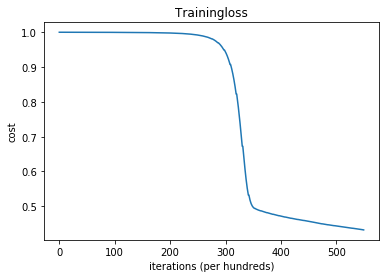

weights saved successfully


In [18]:
#training the model
NeuralNet1=Layer(2,[2,5],activation=['linear'])
NeuralNet2=Layer(4,[8,15,11,2],activation=['relu','relu','linear'])
epochs=500
lr1=0.1
lr2=0.01
train.Train(X_net1_train_scaled.T,X_net2_train_scaled.T,Y_train_scaled.T,NeuralNet1,NeuralNet2,epochs,lr1,lr2,printcost=True)
trainedNet1,trainedNet2=loadmodel.load_weights()

In [19]:
Ypred=train.Predict(X_net1_train_scaled.T,X_net2_train_scaled.T,trainedNet1,trainedNet2)

In [20]:
print('TRAINING LOSS :'+str((mse(Ypred.T,Y_train_scaled))))


TRAINING LOSS :0.43184524226614085


In [21]:
Ypred_cv=train.Predict(X_net1_cv_scaled.T,X_net2_cv_scaled.T,trainedNet1,trainedNet2) #FITTING CV SET

In [22]:
print('CROSS VALIDATION LOSS :'+ str(mse(Ypred_cv.T,Y_cv_scaled)))

CROSS VALIDATION LOSS :0.44724037774938386


In [23]:
#EVALUATION WITH TEST SET
Ypred_test=train.Test(X_test_net1_scaled.T,X_test_net2_scaled.T,test_days,trainedNet1,trainedNet2) 

In [24]:
print('TEST LOSS : ' + str(mse(Ypred_test,y_test_data_scaled.T)))

TEST LOSS : 0.41308501077655885
